In [150]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import datetime
from scipy.optimize import curve_fit
import time
from scipy.interpolate import interp1d
import math
from osgeo import gdal
from osgeo import osr

In [549]:
T = 1 # period of 1 year for seasonal cycle
OUTLIER = 30 # min amount of "good" data required
NUM_ITERS = 2 # total number of outlier removal/fit iterations
SMALL_DT = 20 # days
LONG_DT = 365.25 # days

In [152]:
def open_datacube(directory):
    '''
    directory, str: filename of the datacube to open
    
    return the datacube as an xarray dataset
    '''
    with xr.open_dataset(directory, decode_timedelta=False) as ds:
        data = ds
    return data

In [153]:
def displacement(t, c1, c2): # displacement function, takes in image pair
    t1, t2 = t
    return c1*T/(2*np.pi) * (np.cos(2*np.pi*t1/T) - np.cos(2*np.pi*t2/T)) + c2*T/(2*np.pi) * (np.sin(2*np.pi*t2/T) - np.sin(2*np.pi*t1/T))

In [154]:
def velocity(t, a, ph): # velocity function
    return a * np.sin(2*np.pi*(t+ph)/T)

In [427]:
def prediction_iteration(cell, v_error, dyr, im1, im2, residuals=None):
    '''
    cell, DataArray: the velocity measurements at a grid cell with cooridnates (cell.grid_cell)
    v_error, np.array: error in velocity measurement
    dyr, np.array: time difference (in years) between first and second image
    im1, np.array: dates of first image
    im2, np.array: dates of second image
    
    returns None if the cell was thrown out due to not enough valid data points (too many outliers)
    
    A single iteration of removing outliers and predicted the sinusoid
    '''
    err_nan = np.invert(np.isnan(v_error))
    
    if residuals is None: # first iteration
        outlier_mask = is_outlier(cell) * err_nan
    else: # other iterations
        outlier_mask = is_outlier(residuals)
    result = run_predict(cell, v_error, dyr, outlier_mask, [im1, im2])
    
    return result

In [324]:
def is_outlier(data): # filter out outliers (> 3 median-absolute-deviations away from the median)
    '''
    data, DataArray
    
    returns a DataArray of booleans where True indicates an outlier
    
    Filter out outliers (> 3 median-absolute-deviations away from the median)
    '''
    med = np.nanmedian(data.values)
    threshold = abs(2.5 * 1.4826 * med)
    upper_threshold = med + threshold
    lower_threshold = med - threshold
    mask1 = data <= upper_threshold
    mask2 = data >= lower_threshold
    mask = mask1.values * mask2.values
    return mask

In [457]:
def run_predict(cell, v_error, dyr, mask, images):
    '''
    cell, DataArray: the velocity measurements at a grid cell with cooridnates (cell.grid_cell)
    v_error, np.array: error in velocity measurement
    dyr, np.array: time difference (in years) between first and second image
    mask, np.array: the array of booleans indicated whether the value is an outlier or not
    images: a list of arrays with images[0] being the dates of the first image and images[1] being the dates of the second
    
    returns 
        a, float: amplitude of velocity sinusoid
        ph, float: phase of velocity sinusoid
        peak, float: peak of velocity sinusoid
        removed, DataArray: the velocity with the outliers and interannual variability removed
        v_error_rem, np.array: the velocity error with the outliers and interannual variability removed
        dyr_rem, np.array: the dyrs with the outliers and interannual variability removed
        im1_rem, np.array: the im1s with the outliers and interannual variability removed
        im2_rem, np.array: the im2s with the outliers and interannual variability removed
        
    Removes the outliers, interannual variability, calculates the displacement, then predicts the velocity sinusoid
    '''
    im1, im2 = images

    if np.sum(mask) > OUTLIER: # only use grid cell if it has at least OUTLIER good values
        #filter outliers
        mid_dates_cell = cell.mid_date[mask].values
        cell = cell[mask]
        dyr_cell = dyr[mask]
        v_error_cell = v_error[mask]

        w_d = 1/(v_error_cell * dyr_cell) # calculate weights

        # remove interannual variability
        ia_removed = remove_interannual_var(cell, mid_dates_cell, v_error_cell)

        # only use data with dts between SMALL_DT and LONG_DT (converted to years here)
        m1 = dyr_cell > SMALL_DT/365.25
        m2 = dyr_cell < LONG_DT/365.25
        mask2 = m1*m2

        if sum(mask2) > OUTLIER: # only use grid cell if it has at least OUTLIER good values
            #filter out short and long dt values
            removed = ia_removed[mask2]
            dyr_cell = dyr_cell[mask2]
            im1_cell = np.array(list(map(datetime.date.toordinal, im1[mask].astype('M8[D]').astype('O'))))
            im2_cell = np.array(list(map(datetime.date.toordinal, im2[mask].astype('M8[D]').astype('O'))))

            # calculate the displacement of each image pair (not cumulative displacement)
            disp_rem = dyr_cell * removed.values
            
            #remove nan values
            rem_mask = np.isnan(disp_rem) == False
            disp_rem = disp_rem[rem_mask]
            im1_rem = im1_cell[mask2]
            im1_rem = im1_rem[rem_mask]
            im2_rem = im2_cell[mask2]
            im2_rem = im2_rem[rem_mask]
            dyr_rem = dyr_cell[rem_mask]
            w_d_rem = w_d[mask2]
            w_d_rem = w_d_rem[rem_mask]
            v_error_rem = v_error_cell[mask2]
            v_error_rem = v_error_rem[rem_mask]
            
            # predict amplitude, phase, and peak
            a, ph, peak = predict_params(disp_rem, im1_rem, im2_rem, w_d_rem)

            return a, ph, peak, removed, v_error_rem, dyr_rem, im1_rem, im2_rem

In [455]:
def remove_interannual_var(cell, mid_dates_cell, v_error_cell):
    '''
    cell, DataArray: the velocity measurements at a grid cell with cooridnates (cell.grid_cell)
    mid_dates_cell, np.array: the mid dates of the cell
    v_error_cell, np.array: error in velocity measurement of the cell
    min_date, int: the min year of the data in the cell
    max_date, int: the max year of the data in the cell
    
    returns the cell with the interannual variability removed
    
    Interpolate a spline fit to weighted mean of the velocities for each year and remove it from the velocities
    '''
    # convert dates to number of days since the first of that year
    as_dates = mid_dates_cell.astype('M8[ms]').astype('O')
    all_years = np.array(list(map(datetime.date.isocalendar, as_dates)))[:,0]
    yday = np.array(list(map(datetime.date.timetuple, as_dates)))[:,-2]
    min_date = min(all_years)
    max_date = max(all_years)
    
    #initialize weighted velocity and date arrays
    weighted_vels = np.zeros(max_date - min_date + 1)
    weighted_dates_ord = np.zeros(max_date - min_date + 1)
    
    # weights
    weights = 1/v_error_cell**2
       
    # calculate weighted mean and date of the velocities for each year
    for year in range(min_date, max_date+1):
        i = year - min_date
        first = datetime.date(year, 1, 1).toordinal()
        ind = all_years == year

        if len(weights[ind]) == 0:
            weighted_vels[i] = weighted_vels[i-1] # if no values for that year, fill in with previous mean
            weighted_dates_ord[i] = 365.25/2 + first # middle of year
            
        else:
            weighted_vels[i] = np.sum(weights[ind]*cell.values[ind]) / np.sum(weights[ind])
            weighted_dates_ord[i] = (np.sum(weights[ind]*yday[ind]) / np.sum(weights[ind])) + first

    # interpolate a spline fit
    first = min(weighted_dates_ord)
    last = max(weighted_dates_ord)
    f = interp1d(weighted_dates_ord, weighted_vels, kind='cubic')
    xnew = np.linspace(first, last, num=len(weighted_vels), endpoint=True)
    ia_var = f(xnew)

    ia_removed = []
    
    # remove the interannual variability of each year
    for year in range(min_date, max_date+1):
        ind = all_years == year

        cell_year = cell[ind]
        index = year - min_date
        removed_ia_var = cell_year - ia_var[int(index)]

        ia_removed.append(removed_ia_var)

    ia_rem = xr.concat(ia_removed, 'mid_date')
    
    return ia_rem

In [443]:
def predict_params(disp, im1, im2, w):
    '''
    disp: displacement calculated from velocity
    im1: dates of first image
    im2: dates of second image
    w: weight
    
    return the amplitude, phase, and peak of the velocity sinusoid
    
    Calculations done in years (velocity units were m/yr), using the displacement curve
    '''
    param, param_cov = curve_fit(displacement, [im1/365.25, im2/365.25], disp, sigma = w) # least squares fit to displacement
    c1, c2 = param
    
    # convert coefficients to amplitude and phase of velocity sinusoid (using trig identities)
    a = math.hypot(c1, c2)
    
    ph_rad = math.atan2(c2, c1)
    ph = ph_rad/(2*np.pi)
    
    peak = 365.25*(0.25 - ph_rad/(2*np.pi) % 1) # day where velocity is max 
    if peak < 0: # scale peak day if negative
        peak += 365.25
        
    return a, ph, peak

In [519]:
def days_to_months(days, x, y):
    '''
    days, 1d np.array: number of days since the beginning of the year
    x, DataArray: the x coordinates of the data cube
    y, DataArray: the y coordinates of the data cube
    
    returns the month number of the days
    '''
    new_days = (np.array(days.astype(float)) + datetime.date(2000, 1, 1).toordinal())
    all_days = np.array([datetime.date.fromordinal(p.astype(int)) if np.isnan(p)==False else p for p in new_days])

    months = np.array([p if type(p)==np.float64 else p.month for p in all_days])
    months = np.reshape(months, (len(x), len(y)))
    months = xr.DataArray(months, dims=("x", "y"), coords={'x':x, 'y':y})
    return months

In [547]:
def geotiff_creation(data, x, y, filename):
    '''
    data, 2d np.array: the information you want to create a geotiff of, dimensions- array[y][x]
    x, DataArray: the x coordinates of the data cube (projection coords)
    y, DataArray: the y coordinates of the data cube (projection coords)
    filename, str: the name of the output file
    
    Creates a geotiff file from data using a projection (32622) coordinate system
    '''
    #  Initialize the Image Size
    image_size = data.shape
    
    pos_x = [min(x).values.item(), max(x).values.item()]
    pos_y = [min(y).values.item(), max(y).values.item()]
    
    # Geographic Transform
    nx = image_size[0]
    ny = image_size[1]
    xmin, ymin, xmax, ymax = [min(pos_x), min(pos_y), max(pos_x), max(pos_y)]
    xres = (xmax - xmin) / float(nx)
    yres = (ymax - ymin) / float(ny)

    geotransform = (xmin, xres, 0, ymax, 0, -yres) # set geotransform
    
    dst_ds = gdal.GetDriverByName('GTiff').Create(filename + '.tif', ny, nx, 1, gdal.GDT_Float64)

    dst_ds.SetGeoTransform(geotransform)    # specify coords
    srs = osr.SpatialReference()            # establish encoding
    srs.ImportFromEPSG(32622)                # projection (not lat/lon coords)
    dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    dst_ds.GetRasterBand(1).WriteArray(data)   # write band to the raster
    dst_ds.FlushCache()                     # write to disk
    dst_ds = None

In [160]:
greenland_dir = 'data/Greenland_61.6N_48.1W.nc' # filename of data cube
gl_cube = open_datacube(greenland_dir)

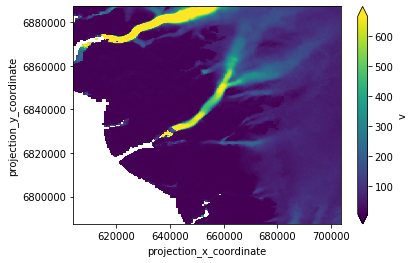

In [161]:
# calculate and plot median velocity
gl_median = gl_cube.v.median(dim='mid_date')
gl_median.plot(x='x', y='y', robust=True)
plt.show()

In [162]:
sorted_cube = gl_cube.sortby('acquisition_img2') # sort the data cube by date of first image taken

In [163]:
v = sorted_cube.v # velocities
x = sorted_cube.x # x coords (projection)
y = sorted_cube.y # y coords (projection)
mid_dates = sorted_cube.mid_date # center date of the image pair
im1 = sorted_cube.acquisition_img2 # dates of the first image
im2 = sorted_cube.acquisition_img1 # dates of the second image
dts = sorted_cube.date_dt # time (in days) between first and second image
dyr = dts/365.25 # time (in years) between first and second image
v_error = np.sqrt(sorted_cube.vx_error**2 + sorted_cube.vy_error**2) # error in velocity

In [164]:
v2 = v.stack(grid_cell=("x", "y")) # reshape velocity into 2d matrix, each row is a grid cell

In [460]:
# initialize arrays for amplitude, phase, and peak months
amps = np.full(v2.sizes['grid_cell'], np.nan) # amplitude of velocity sinusoid, in m
phases = np.full(v2.sizes['grid_cell'], np.nan) # phase shift of the velocity sinusoid in yr
peaks = np.full(v2.sizes['grid_cell'], np.nan, dtype=datetime.date) # day of peak of the velocity sinusoid (days after the first of the year)

In [461]:
start = time.time()

In [462]:
empty = 0 # number of empty cells
discarded = 0 # number of cells discarded as an outlier

for i in range(v2.sizes['grid_cell']):
    if i%10000==0:
            print(i, time.time() - start)
    
    cell = v2[:, i]
    cell = cell.where(cell.mid_date > np.datetime64("2000")) # only use data from 2000 or later

    if sum(np.isnan(cell.values)) == cell.values.size: # empty cell
        empty += 1
    
    else:
        try:
            v_error_cell = v_error.values
            dyr_cell = dyr.values
            im1_cell = im1.values
            im2_cell = im2.values

            #first iteration
            result = prediction_iteration(cell, v_error_cell, dyr_cell, im1_cell, im2_cell)

            if result != None:
                a, ph, peak, cell, v_error_cell, dyr_cell, im1_cell, im2_cell = result

                for n in range(NUM_ITERS - 1): # iterations of removing outliers and predicting fit
                    pred_mid_dates = np.array(list(map(datetime.date.toordinal, cell.mid_date.values.astype('M8[D]').astype('O'))))
                    pred_vels = velocity(pred_mid_dates/365.25, a, ph)
                    residuals = xr.DataArray(abs(pred_vels - cell.values))

                    result = prediction_iteration(cell, v_error_cell, dyr_cell, im1_cell, im2_cell, residuals)

                    if result != None:
                        a, ph, peak, cell, v_error_cell, dyr_cell, im1_cell, im2_cell = result
                    else:
                        break
        except:
            print(i)
            raise
            
        if result != None: # add predicted value to array
            amps[i] = a
            phases[i] = ph
            peaks[i] = peak
            
        else:
            discarded += 1

0 0.23158907890319824
10000 334.9712061882019
20000 724.1674790382385
30000 1254.988597393036
40000 1829.2176351547241
50000 2469.5544402599335
60000 3123.795562982559
70000 3822.4877891540527
80000 4608.050273180008
90000 5351.63450717926
100000 6182.355492115021
110000 6968.053615093231
120000 7666.373185157776
130000 8305.04622721672
140000 8853.285848140717
150000 9361.632645130157
160000 9893.466259241104
170000 10405.41938829422


In [463]:
end = time.time()
print(end - start)

10558.535935401917


In [583]:
# put all info into a DataSet
# make data into a 2d array, array[y][x]
new_amps = np.transpose(np.reshape(amps, (len(x), len(y))))
new_peaks = np.transpose(np.reshape(peaks, (len(x), len(y))))
new_phases = np.transpose(np.reshape(phases * 365.25, (len(x), len(y))))

# make DataArrays
all_amps = xr.DataArray(new_amps, dims=("y", "x"), coords={'y':y, 'x':x})
all_peaks = xr.DataArray(new_peaks, dims=("y", "x"), coords={'y':y, 'x':x})
all_phases = xr.DataArray(new_phases, dims=("y", "x"), coords={'y':y, 'x':x})

result_ds = xr.Dataset({'amplitude': all_amps, 'phase': all_phases, 'peak': all_peaks})

In [584]:
# save the netcdf
result_ds.to_netcdf("results.nc")

In [585]:
# save the 2d arrays
np.savetxt("amps.csv", new_amps, delimiter=",")
np.savetxt("peaks.csv", new_peaks, delimiter=",")
np.savetxt("phases.csv", new_phases, delimiter=",")

Amplitude (m):


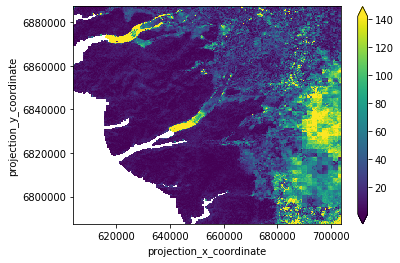

Peak Month:


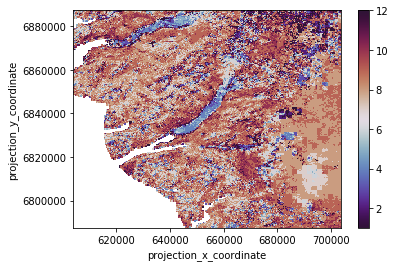

Phase Shift (days):


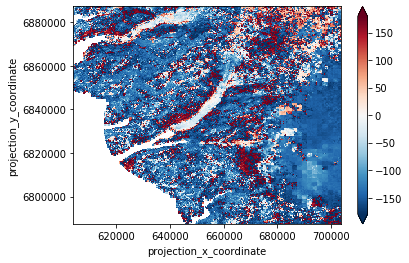

In [586]:
# plotting
print('Amplitude (m):')
all_amps.plot(x='x', y='y', robust=True)
plt.show()

print('Peak Month:')
peak_months = days_to_months(peaks, x, y)
peak_months.plot(x='x', y='y', cmap='twilight_shifted')
plt.show()

print('Phase Shift (days):')
all_phases.plot(x='x', y='y', robust=True)
plt.show()

In [588]:
# create geoTIFFs
geotiff_creation(new_amps, x, y, 'ampsTIFF')
geotiff_creation(new_peaks, x, y, 'peaksTIFF')
geotiff_creation(new_phases, x, y, 'phasesTIFF')
geotiff_creation(gl_median.values, x, y, 'medianTIFF')